# Classificador de Turabão

## Propósito

O prósito deste artigo é criar um classificar capaz de diferir entre algumas espécies de tubarão. A aplicação ficará disponível no HuggingFace Spaces para quem tiver interrese em testa-lá. Para a rede Neural nós iremos utilizar a resnet18 atráves da biblioteca do fastai, e para a busca do nosso banco de imagens será utilizado o duckduckgo_search.

## Coleta de Dados

O primeiro passo para desenvolver nosso modelo é ter em mãos o nosso conjunto de dados, e para começar a coleta nós iremos utilizar o método ddg_images para conseguir um array com os ULRL's dos termos de pesquisa desejado

In [16]:
from duckduckgo_search import ddg_images
from fastcore.all import *

In [17]:
def search_images(term, max_images=500):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [18]:
urls = search_images('shark', max_images=1)
urls[0]

'http://snowbrains.com/wp-content/uploads/2015/01/Seapics-GWS3.jpg'

Para o download das imagens, utilizaremos o download_url do próprio fastai

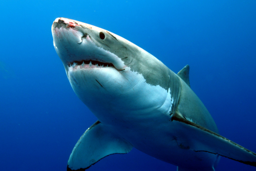

In [19]:
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.data import *

dest = 'shark.jpg'
download_url(urls[0], dest, show_progress=True)

img01 = Image.open(dest)
img01.to_thumb(256, 256)

Como está tudo funcionando como deveria, vamos baixar todo o conjunto de dados que será utlizado no treinamento do nosso modelo

In [20]:
sharks = 'Whale', 'Tiger', 'Hammerhead', 'Great White'
path = Path('sharks')

In [12]:
for shark in sharks:
        dest = (path/shark)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{shark} shark'))

/home/rafael/workEnv/ml_23_2/.venv/lib/python3.11/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/rafael/workEnv/ml_23_2/.venv/lib/python3.11/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/rafael/workEnv/ml_23_2/.venv/lib/python3.11/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

15

Agora que nós temos nosso conjunto de dados, precisamos criar as regras do nosso Data Set, e para isso utilizados a classe DataBlock() do fastai, onde definimos como será dividido e como será filtrado as imagens na hora do treinamento do modelo

In [21]:
sks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

/home/rafael/workEnv/ml_23_2/.venv/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


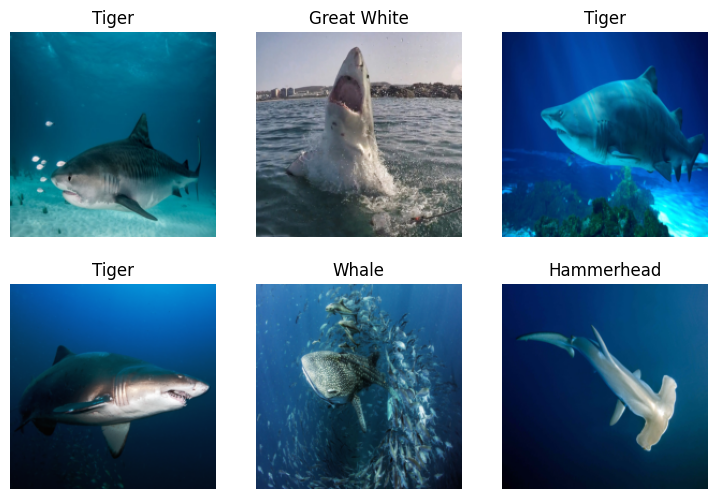

In [10]:
sks.show_batch(max_n=6)

## Treinamento do modelo

Agora que nós temos nosso conjunto de dados e as definições de como ele será divido para o treinamento do modelo, vamos iniciar o treinamento!

Nós utilizaremos o vision_learner da biblioteca do fastai com a Rede Neural pré-treinada resnet 18.

In [22]:
learn = vision_learner(sks, resnet18, metrics=error_rate)
learn.fine_tune(5)

/home/rafael/workEnv/ml_23_2/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rafael/workEnv/ml_23_2/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.500672,1.767524,0.482143,00:28


epoch,train_loss,valid_loss,error_rate,time
0,1.156504,1.007423,0.285714,00:35
1,0.884510,0.547984,0.214286,00:31
2,0.662170,0.406289,0.107143,00:30
3,0.511897,0.360460,0.107143,00:31
4,0.416200,0.361091,0.125000,00:30


Agora que temos o modelo treinado, vamos verificar os possíveis erros de validação durante o treinamento

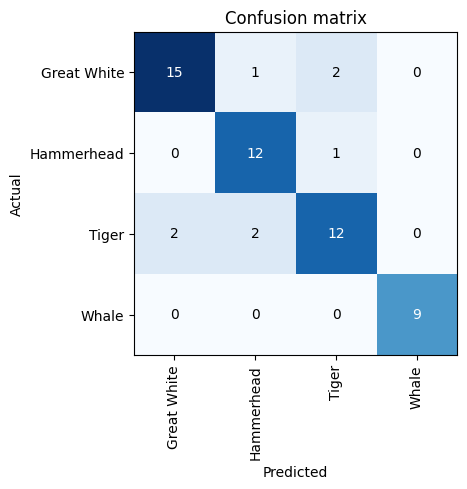

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Com os frames abaixo nós podemos ver os maiores erros ocorridos durante o treinamento

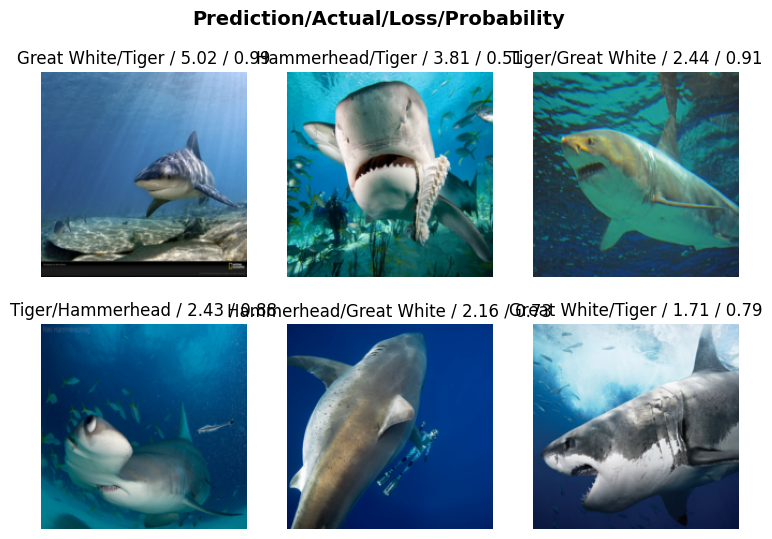

In [13]:
interp.plot_top_losses(6, nrows=2)

Para corrigir alguns destes erros, vamos utilizar um cleaner, onde ele permite a correção de erros ou mudança de label manualmente

In [45]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

## Testando nosso modelo

Agora que nosso modelo está treinado, podemos testa-lo com algumas imagens:

It is a Great White shark
Probability: 1.0000


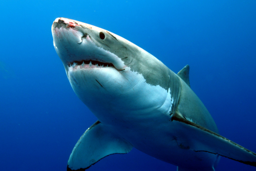

In [27]:
#download_url(search_images('great white shark', max_images=10)[6], 'gshark.jpg', show_progress=False)
which_shark,_,probs = learn.predict(PILImage.create('gshark.jpg'))
print(f'It is a {which_shark} shark')
print(f'Probability: {probs[0]:.4f}')
Image.open('shark.jpg').to_thumb(256,256)

It is a Hammerhead shark
Probability: 0.9965


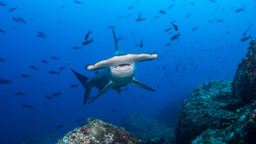

In [24]:
download_url(search_images('hammerhead shark', max_images=10)[6], 'hshark.jpg', show_progress=False)
which_shark,_,probs = learn.predict(PILImage.create('hshark.jpg'))
print(f'It is a {which_shark} shark')
print(f'Probability: {probs[1]:.4f}')
Image.open('hshark.jpg').to_thumb(256,256)

It is a Tiger shark
Probability: 0.9996


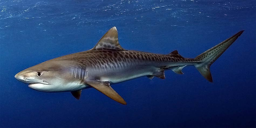

In [25]:
download_url(search_images('tiger shark', max_images=10)[6], 'tshark.jpg', show_progress=False)
which_shark,_,probs = learn.predict(PILImage.create('tshark.jpg'))
print(f'It is a {which_shark} shark')
print(f'Probability: {probs[2]:.4f}')
Image.open('tshark.jpg').to_thumb(256,256)

It is a Whale shark
Probability: 0.9999


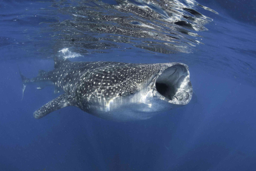

In [29]:
#download_url(search_images('whale shark', max_images=2)[1], 'wshark.jpg', show_progress=False)
which_shark,_,probs = learn.predict(PILImage.create('wshark.jpg'))
print(f'It is a {which_shark} shark')
print(f'Probability: {probs[3]:.4f}')
Image.open('wshark.jpg').to_thumb(256,256)

## Exportando nosso modelo

Agora vamos criar uma aplicação no HugginFace, mas antes, precisamos exportar os pesos do nosso modelo

In [17]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Link para a aplicação no HugginFace

https://huggingface.co/spaces/rafaelcarvalhoj/shark-classifier